In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
# Set path to the directory where you uploaded the dataset
data_dir = "/kaggle/working/data"

In [2]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32
EPOCHS = 30
lr = 0.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_data = CIFAR10(
    root=data_dir,
    train=True,
    transform=ToTensor(),
    download=True  # Set to False since data is already downloaded
)

test_data = CIFAR10(
    root=data_dir,
    train=False,
    transform=ToTensor(),
    download=True
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# See first training sample
class_names = train_data.classes
image, label = train_data[0]
image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [5]:
from torch.utils.data import DataLoader

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

In [6]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn,
               device: torch.device = device):
    train_cost, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_cost += loss
        
        acc = acc_fn(y,y_pred.argmax(dim=1)) # Go from logits -> pred labels
        train_acc += acc
    
        
        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_cost /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_cost:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_cost, train_acc

def test_step(data_loader: torch.utils.data.DataLoader,
              model: nn.Module,
              loss_fn: nn.Module,
              acc_fn,
              device: torch.device = device):
    test_cost, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            loss = loss_fn(test_pred, y)
            test_cost += loss

            acc = acc_fn(y, test_pred.argmax(dim=1)) # Go from logits -> pred labels
            test_acc += acc

        # Adjust metrics and print out
        test_cost /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_cost:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_cost, test_acc

In [7]:
# Create a convolutional neural network
class CNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model = CNN(input_shape=3, hidden_units=256, output_shape=10).to(device)
model

CNN(
  (block_1): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=10, bias=True)
  )
)

In [8]:
%pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [9]:
# Setup loss function and optimizer
import torchmetrics
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)
acc_fn = torchmetrics.Accuracy(task = 'multiclass', num_classes=10).to(device)

In [10]:
torch.manual_seed(42)
from tqdm import tqdm
# Train and test model
train_cost = []
train_acc = []
test_cost = []
test_acc = []
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n---------")
    train_loss, tem_acc = train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        acc_fn=acc_fn,
        device=device
    )
    train_cost.append(train_loss)
    train_acc.append(tem_acc)
    
    test_loss, acc = test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        acc_fn=acc_fn,
        device=device
    )    
    test_cost.append(test_loss)
    test_acc.append(acc)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.66993 | Train accuracy: 0.40%


  3%|▎         | 1/30 [00:47<22:43, 47.02s/it]

Test loss: 1.30227 | Test accuracy: 0.53%

Epoch: 1
---------
Train loss: 1.05286 | Train accuracy: 0.63%


  7%|▋         | 2/30 [01:30<20:57, 44.93s/it]

Test loss: 1.25703 | Test accuracy: 0.57%

Epoch: 2
---------
Train loss: 0.80244 | Train accuracy: 0.72%


 10%|█         | 3/30 [02:15<20:13, 44.96s/it]

Test loss: 0.80523 | Test accuracy: 0.73%

Epoch: 3
---------
Train loss: 0.63561 | Train accuracy: 0.78%


 13%|█▎        | 4/30 [02:59<19:21, 44.68s/it]

Test loss: 0.81975 | Test accuracy: 0.72%

Epoch: 4
---------
Train loss: 0.50982 | Train accuracy: 0.82%


 17%|█▋        | 5/30 [03:44<18:37, 44.72s/it]

Test loss: 0.81926 | Test accuracy: 0.73%

Epoch: 5
---------
Train loss: 0.39858 | Train accuracy: 0.86%


 20%|██        | 6/30 [04:29<17:51, 44.65s/it]

Test loss: 0.82103 | Test accuracy: 0.75%

Epoch: 6
---------
Train loss: 0.30705 | Train accuracy: 0.89%


 23%|██▎       | 7/30 [05:13<17:04, 44.55s/it]

Test loss: 1.03316 | Test accuracy: 0.70%

Epoch: 7
---------
Train loss: 0.23285 | Train accuracy: 0.92%


 27%|██▋       | 8/30 [05:57<16:18, 44.47s/it]

Test loss: 0.90741 | Test accuracy: 0.75%

Epoch: 8
---------
Train loss: 0.18394 | Train accuracy: 0.93%


 30%|███       | 9/30 [06:41<15:31, 44.36s/it]

Test loss: 1.01335 | Test accuracy: 0.75%

Epoch: 9
---------
Train loss: 0.15490 | Train accuracy: 0.95%


 33%|███▎      | 10/30 [07:25<14:45, 44.29s/it]

Test loss: 1.09035 | Test accuracy: 0.75%

Epoch: 10
---------
Train loss: 0.13737 | Train accuracy: 0.95%


 37%|███▋      | 11/30 [08:09<13:59, 44.17s/it]

Test loss: 1.26316 | Test accuracy: 0.74%

Epoch: 11
---------
Train loss: 0.12794 | Train accuracy: 0.96%


 40%|████      | 12/30 [08:53<13:13, 44.08s/it]

Test loss: 1.56048 | Test accuracy: 0.71%

Epoch: 12
---------
Train loss: 0.11141 | Train accuracy: 0.96%


 43%|████▎     | 13/30 [09:37<12:27, 43.97s/it]

Test loss: 1.32307 | Test accuracy: 0.76%

Epoch: 13
---------
Train loss: 0.10961 | Train accuracy: 0.96%


 47%|████▋     | 14/30 [10:21<11:41, 43.87s/it]

Test loss: 1.38255 | Test accuracy: 0.74%

Epoch: 14
---------
Train loss: 0.10904 | Train accuracy: 0.96%


 50%|█████     | 15/30 [11:04<10:57, 43.82s/it]

Test loss: 1.41423 | Test accuracy: 0.75%

Epoch: 15
---------
Train loss: 0.09931 | Train accuracy: 0.97%


 53%|█████▎    | 16/30 [11:48<10:12, 43.74s/it]

Test loss: 1.51748 | Test accuracy: 0.75%

Epoch: 16
---------
Train loss: 0.10816 | Train accuracy: 0.96%


 57%|█████▋    | 17/30 [12:31<09:27, 43.62s/it]

Test loss: 1.45152 | Test accuracy: 0.75%

Epoch: 17
---------
Train loss: 0.09522 | Train accuracy: 0.97%


 60%|██████    | 18/30 [13:15<08:42, 43.58s/it]

Test loss: 1.75820 | Test accuracy: 0.72%

Epoch: 18
---------
Train loss: 0.11580 | Train accuracy: 0.96%


 63%|██████▎   | 19/30 [13:58<07:58, 43.46s/it]

Test loss: 1.43107 | Test accuracy: 0.75%

Epoch: 19
---------
Train loss: 0.09391 | Train accuracy: 0.97%


 67%|██████▋   | 20/30 [14:41<07:13, 43.36s/it]

Test loss: 1.86826 | Test accuracy: 0.74%

Epoch: 20
---------
Train loss: 0.10726 | Train accuracy: 0.97%


 70%|███████   | 21/30 [15:24<06:29, 43.30s/it]

Test loss: 1.63310 | Test accuracy: 0.73%

Epoch: 21
---------
Train loss: 0.11270 | Train accuracy: 0.96%


 73%|███████▎  | 22/30 [16:07<05:45, 43.22s/it]

Test loss: 1.86278 | Test accuracy: 0.75%

Epoch: 22
---------
Train loss: 0.11705 | Train accuracy: 0.96%


 77%|███████▋  | 23/30 [16:50<05:02, 43.17s/it]

Test loss: 1.77765 | Test accuracy: 0.73%

Epoch: 23
---------
Train loss: 0.10996 | Train accuracy: 0.97%


 80%|████████  | 24/30 [17:33<04:18, 43.11s/it]

Test loss: 1.96413 | Test accuracy: 0.73%

Epoch: 24
---------
Train loss: 0.09659 | Train accuracy: 0.97%


 83%|████████▎ | 25/30 [18:16<03:35, 43.08s/it]

Test loss: 2.01308 | Test accuracy: 0.75%

Epoch: 25
---------
Train loss: 0.13874 | Train accuracy: 0.96%


 87%|████████▋ | 26/30 [18:59<02:52, 43.04s/it]

Test loss: 2.05490 | Test accuracy: 0.69%

Epoch: 26
---------
Train loss: 0.14060 | Train accuracy: 0.96%


 90%|█████████ | 27/30 [19:42<02:08, 42.99s/it]

Test loss: 1.81957 | Test accuracy: 0.75%

Epoch: 27
---------
Train loss: 0.13363 | Train accuracy: 0.96%


 93%|█████████▎| 28/30 [20:25<01:25, 42.95s/it]

Test loss: 2.27145 | Test accuracy: 0.69%

Epoch: 28
---------
Train loss: 0.15123 | Train accuracy: 0.96%


 97%|█████████▋| 29/30 [21:08<00:42, 42.88s/it]

Test loss: 1.94237 | Test accuracy: 0.73%

Epoch: 29
---------
Train loss: 0.14796 | Train accuracy: 0.96%


100%|██████████| 30/30 [21:50<00:00, 43.69s/it]

Test loss: 2.34335 | Test accuracy: 0.72%



In [11]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [12]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 32, 32])
Test sample label: 9 (truck)


In [13]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.1165e-22, 4.4421e-27, 2.1925e-36, 3.2999e-36, 4.4384e-31, 1.0430e-27,
         3.3585e-33, 1.8371e-27, 3.4850e-28, 1.0000e+00],
        [1.0629e-12, 2.5111e-16, 2.0077e-03, 7.9132e-11, 9.9799e-01, 1.3755e-09,
         6.9094e-14, 3.9455e-10, 4.7101e-13, 1.1598e-12]])

In [14]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 4, 1, 7, 7, 5, 7, 0, 9])

In [15]:
def plot_predictions(test_samples, test_labels, pred_classes, class_names, nrows=3, ncols=3, figsize=(9, 9)):
    """
    Plot the predictions alongside the target labels.

    Args:
        test_samples (list): List of input samples to display (e.g., tensors or arrays).
        test_labels (list): Ground truth labels for the test samples.
        pred_classes (list): Predicted class indices for the test samples.
        class_names (list): List of class names corresponding to class indices.
        nrows (int): Number of rows in the plot grid (default: 3).
        ncols (int): Number of columns in the plot grid (default: 3).
        figsize (tuple): Size of the figure (default: (9, 9)).
    """
    plt.figure(figsize=figsize)
    for i, sample in enumerate(test_samples[:nrows * ncols]):
        # Create a subplot
        plt.subplot(nrows, ncols, i + 1)

        # If the sample has 3 channels, permute dimensions for Matplotlib
        if sample.shape[0] == 3:
            sample = sample.permute(1, 2, 0)

        # Plot the image
        plt.imshow(sample.squeeze(), cmap=None if sample.ndim == 3 else "gray")

        # Find the prediction label (in text form)
        pred_label = class_names[pred_classes[i]]

        # Get the truth label (in text form)
        truth_label = class_names[test_labels[i]]

        # Create the title text of the plot
        title_text = f"Pred: {pred_label} | Truth: {truth_label}"

        # Check for equality and change title color accordingly
        if pred_label == truth_label:
            plt.title(title_text, fontsize=10, c="g")  # Green text if correct
        else:
            plt.title(title_text, fontsize=10, c="r")  # Red text if wrong

        plt.axis(False)
    plt.tight_layout()
    plt.show()

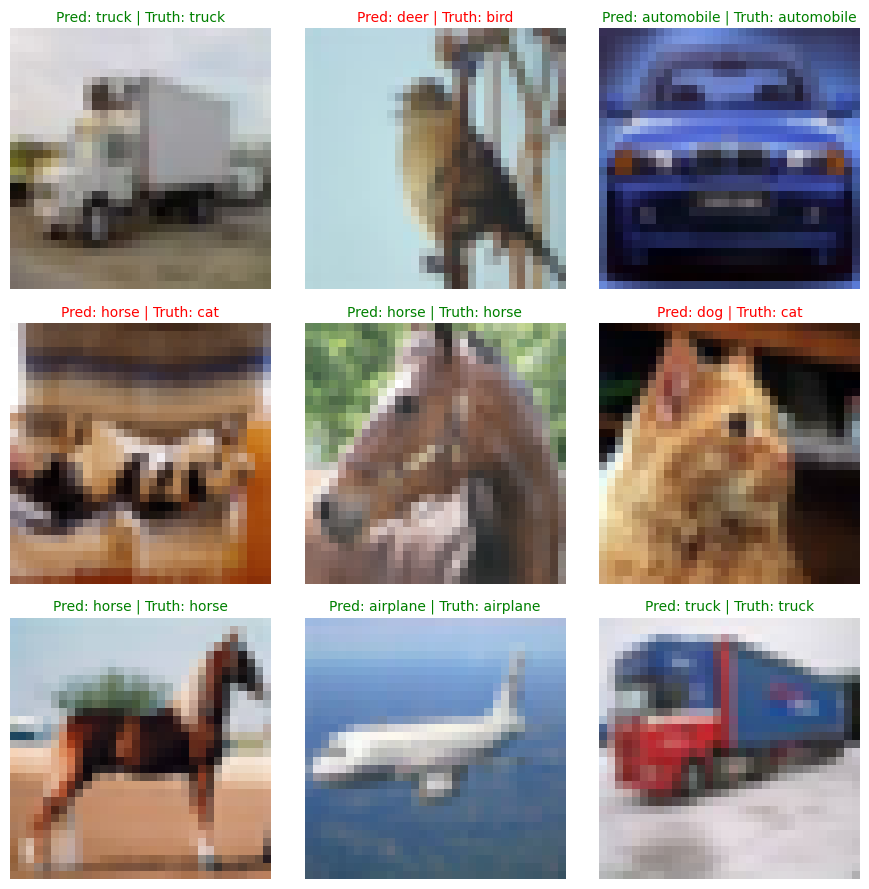

In [16]:
plot_predictions(test_samples, test_labels, pred_classes, class_names)

In [17]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
y_pred_tensor

tensor([3, 0, 8,  ..., 5, 1, 7])

In [19]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [20]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


/tmp/ipykernel_1960/2789026833.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred_tensor = torch.tensor(y_pred_tensor)  # Convert list to tensor if necessary


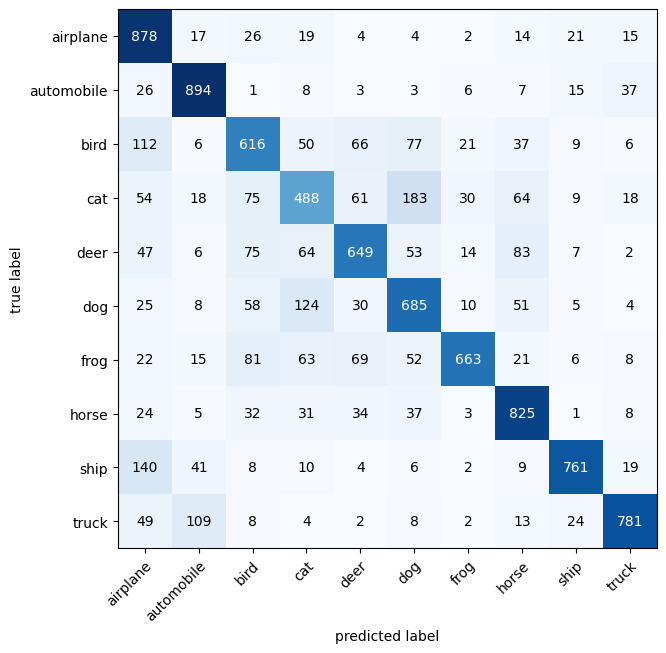

In [21]:
import torch
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Ensure predictions are a tensor
y_pred_tensor = torch.tensor(y_pred_tensor)  # Convert list to tensor if necessary

# Ensure target labels are also a tensor
targets = test_data.targets if isinstance(test_data.targets, torch.Tensor) else torch.tensor(test_data.targets)

# Apply argmax if predictions are logits
if y_pred_tensor.ndim > 1:  # If it's not already class indices
    y_pred_tensor = torch.argmax(y_pred_tensor, dim=1)

# Setup confusion matrix instance
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')

# Compute the confusion matrix tensor
confmat_tensor = confmat(preds=y_pred_tensor, target=targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Convert tensor to numpy for plotting
    class_names=class_names,          # Turn row and column labels into class names
    figsize=(10, 7)
)

In [22]:
import matplotlib.pyplot as plt
import torch

def plot_metrics(train_loss, train_acc, test_loss, test_acc, epochs):
    """
    Plot training and testing loss and accuracy.

    Args:
        train_loss (list): List of training loss values for each epoch (tensors or floats).
        train_acc (list): List of training accuracy values for each epoch (tensors or floats).
        test_loss (list): List of testing loss values for each epoch (tensors or floats).
        test_acc (list): List of testing accuracy values for each epoch (tensors or floats).
        epochs (int): Number of epochs.
    """
    # Convert all tensors to CPU and NumPy if necessary
    train_loss = [tl.cpu().item() if isinstance(tl, torch.Tensor) else tl for tl in train_loss]
    train_acc = [ta.cpu().item() if isinstance(ta, torch.Tensor) else ta for ta in train_acc]
    test_loss = [tl.cpu().item() if isinstance(tl, torch.Tensor) else tl for tl in test_loss]
    test_acc = [ta.cpu().item() if isinstance(ta, torch.Tensor) else ta for ta in test_acc]
    
    epochs_range = range(epochs)

    plt.figure(figsize=(14, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_loss, label="Train Loss")
    plt.plot(epochs_range, test_loss, label="Test Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Testing Loss")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_acc, label="Train Accuracy")
    plt.plot(epochs_range, test_acc, label="Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Testing Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


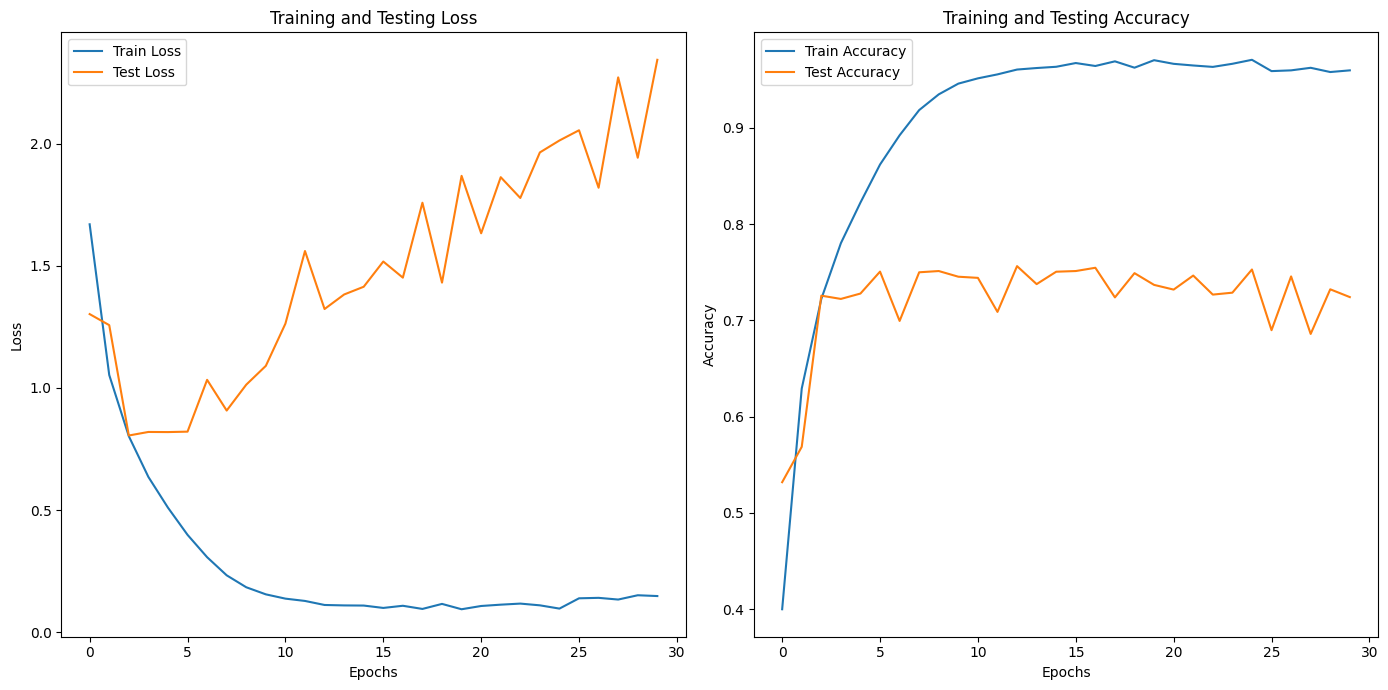

In [23]:
plot_metrics(train_cost, train_acc, test_cost, test_acc, EPOCHS)